In [1]:
!pip install "gymnasium[atari]" ale-py matplotlib torch #need to use python 3.8; newer versions don't work
%matplotlib inline


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


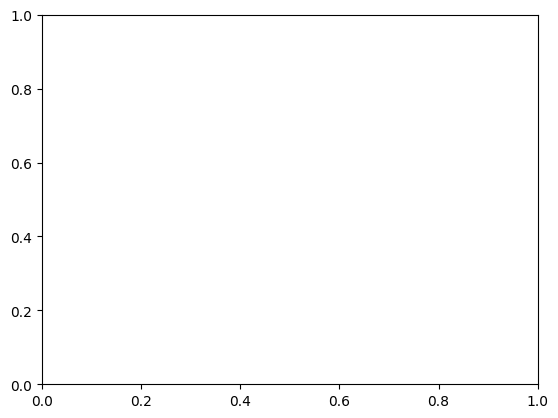

In [2]:
import gymnasium as gym
import ale_py
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

fig, ax = plt.subplots()

gym.register_envs(ale_py)  # unnecessary but helpful for IDEs

env = gym.make('ALE/Pong-v5', obs_type="ram")  # remove render_mode in training

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
#4
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(n_observations, 256),
            nn.ReLU(),
        )
        self.value_stream = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        return value + advantage - advantage.mean(dim=1, keepdim=True)




#3
# class DQN(nn.Module):
#     def __init__(self, n_observations, n_actions):
#         super(DQN, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(n_observations, 512),
#             nn.ReLU(),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, n_actions)
#         )

#     def forward(self, x):
#         return self.net(x)

#2
# class DQN(nn.Module):
#     def __init__(self, n_observations, n_actions):
#         super(DQN, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(n_observations, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, n_actions)
#         )

#     def forward(self, x):
#         return self.net(x)


#1
# class DQN(nn.Module):

#     def __init__(self, n_observations, n_actions):
#         super(DQN, self).__init__()
#         self.layer1 = nn.Linear(n_observations, 128)
#         self.layer2 = nn.Linear(128, 128)
#         self.layer3 = nn.Linear(128, n_actions)

#     # Called with either one element to determine next action, or a batch
#     # during optimization. Returns tensor([[left0exp,right0exp]...]).
#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         return self.layer3(x)

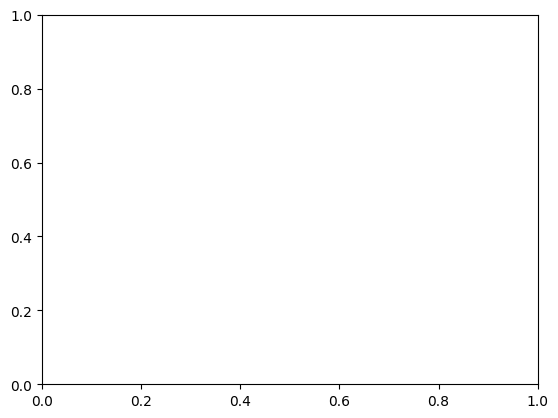

In [5]:
# import matplotlib.pyplot as plt
# from IPython import display

LR = 0.0001
GAMMA = 0.99
BATCH_SIZE = 128
BUFFER_CAPACITY = 10000
TAU = 0.005
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
MAX_STEPS_PER_EPISODE = 600  # edit this??? 

VALID_ACTIONS = [2, 3]
n_actions = len(VALID_ACTIONS)

state, info = env.reset()
n_observations = len(state)

# Networks and optimizer
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(BUFFER_CAPACITY)

steps_done = 0

#reward/success logs
episode_rewards = []
episode_successes = []

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            action_idx = policy_net(state).max(1).indices.item()
    else:
        action_idx = random.randrange(n_actions)
    return torch.tensor([[VALID_ACTIONS[action_idx]]], device=device, dtype=torch.long)

fig, ax = plt.subplots()

def plot_durations(show_result=False):
    ax.clear()
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)

    if show_result:
        ax.set_title('Final Result')
    else:
        ax.set_title('Training...')

    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    ax.plot(rewards_t.numpy(), label='Episode Reward')

    if len(rewards_t) >= 10:
        means = rewards_t.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        ax.plot(means.numpy(), label='10-ep average')

    ax.legend()
    display.clear_output(wait=True)
    display.display(fig)

def plot_success_rate():
    plt.figure()
    successes = torch.tensor(episode_successes, dtype=torch.float)
    plt.plot(successes.numpy(), label='Win (1) / Loss (0)')
    if len(successes) >= 10:
        means = successes.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(means.numpy(), label='10-ep average')
    plt.title("Match Success Rate")
    plt.xlabel("Episode")
    plt.ylabel("Success")
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
print(env.spec.max_episode_steps)

None


In [7]:
#perform one optimazation, eg. samples a batch, put all tensors together, compute loss, and update network


In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

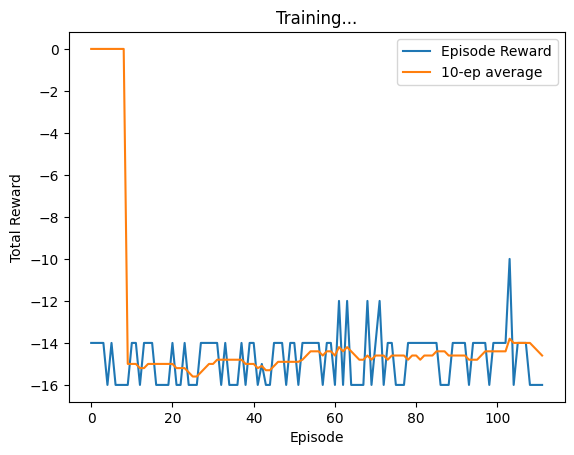

In [ ]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 1000  # More training episodes
else:
    num_episodes = 100

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state / 255.0, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0

    for t in range(MAX_STEPS_PER_EPISODE):
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        total_reward += reward.item()
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation / 255.0, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()

        # Soft update of the target network
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = (
                policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
            )
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

    # === End of episode: log reward and success ===
    episode_rewards.append(total_reward)
    episode_successes.append(1 if total_reward > 0 else 0)
    plot_durations()

    if i_episode % 50 == 0:
        torch.save(policy_net.state_dict(), f"pong_ram_checkpoint_{i_episode}.pt")

print('Complete')
print("Final episode rewards:", episode_rewards)
print("Final episode success flags:", episode_successes)

plot_durations(show_result=True)
plt.ioff()
plt.show()

plt.figure()
plt.plot(episode_rewards)
plt.title("Final Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

plot_success_rate()